# Comparison of Similarity: Semsimian vs. Large Language Model Embeddings

## Case 1: HP vs HP

### Setup

In [3]:
!pip install oaklib==0.5.18rc2 polars seaborn seaborn_polars matplotlib
!pip install git+https://github.com/monarch-initiative/ontogpt.git
# Depending on the environment you may also need python3-dev


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/monarch-initiative/ontogpt.git to /tmp/pip-req-build-887ospo0
  Running command git clone --filter=blob:none --quiet https://github.com/monarch-initiative/ontogpt.git /tmp/pip-req-build-887ospo0
  Resolved https://github.com/monarch-initiative/ontogpt.git to commit 4849f4ce7c54f0394c263fdcad832f7a9eabd52b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn_polars as snl

from ontogpt.clients import OpenAIClient

In [2]:
# This could be generalized to any target
termfile = 'hp_terms.tsv'
simfile = 'hp_vs_hp_semsim.tsv'

### Semsim for HP through Semsimian and OAK

In [14]:
# Retrieve the ontology, get the class list, and process into batches
!runoak -i sqlite:obo:hp descendants -p i HP:0000118 > {termfile}
!split -l 500 --numeric-suffixes {termfile} terms

In [ ]:
# This is just a test set: the descendants of "Abnormality of the voice" - it's only 24 objects
!runoak -vvv -i semsimian:sqlite:obo:hp similarity --no-autolabel -p i .desc//p=i HP:0001608 @ .desc//p=i HP:0001608 -O csv -o {simfile}

The following will do all PA vs all PA for HP. That's pretty large (>17k objects) which is why we use batches.

Plus this is running without a threshold - we really do want to compare everything we can.

This outputs to a single file so we append.

In [16]:
! for batch in terms*; do runoak -vvv -i semsimian:sqlite:obo:hp similarity --no-autolabel -p i --set1-file $batch --set2-file "hp_terms.tsv" -O csv >> 'hp_vs_hp_semsim.tsv'; done

INFO:root:Setting other_languages=()
INFO:root:Settings = Settings(impl=None, autosave=False, associations_type=None, preferred_language=None, other_languages=())
INFO:root:Wrapping an existing OAK implementation to fetch sqlite:obo:hp
INFO:root:Locator: obo:hp
INFO:root:Ensuring gunzipped for https://s3.amazonaws.com/bbop-sqlite/hp.db.gz
INFO:root:Locator, post-processed: sqlite:////home/harry/.data/oaklib/hp.db
DEBUG:root:Paths to search: [PurePosixPath('model/schema'), PurePosixPath('schema'), PurePosixPath('linkml'), PurePosixPath('src/linkml'), PurePosixPath('src/model'), PurePosixPath('src/model/schema'), PurePosixPath('src/schema'), PurePosixPath('.')]
DEBUG:root:candidate model/schema not found
DEBUG:root:candidate schema not found
DEBUG:root:candidate linkml not found
DEBUG:root:candidate src/linkml not found
DEBUG:root:candidate src/model not found
DEBUG:root:candidate src/model/schema not found
DEBUG:root:candidate src/schema not found
INFO:root:out=None <class 'NoneType'>
I

In [25]:
# Output is already concatenated since we appended, but it will have extra headings we need to remove
# But then add the heading again because we still want it
!sed -i '/^subject/d' {simfile}
!sed -i '1s/^/subject_id\tsubject_label\tsubject_source\tobject_id\tobject_label\tobject_source\tancestor_id\tancestor_label\tancestor_source\tobject_information_content\tsubject_information_content\tancestor_information_content\tjaccard_similarity\tcosine_similarity\tdice_similarity\tphenodigm_score\n/' {simfile}

In [26]:
!head {simfile}

subject_id	subject_label	subject_source	object_id	object_label	object_source	ancestor_id	ancestor_label	ancestor_source	object_information_content	subject_information_content	ancestor_information_content	jaccard_similarity	cosine_similarity	dice_similarity	phenodigm_score
HP:0006276	None	None	HP:0001471	None	None	HP:0000118	None	None	None	None	0.8020531768157838	0.14285714285714285	None	None	0.33849523668642323
HP:0006276	None	None	HP:0005329	None	None	HP:0000118	None	None	None	None	0.8020531768157838	0.13333333333333333	None	None	0.32701746677423493
HP:0006276	None	None	HP:0011482	None	None	HP:0000118	None	None	None	None	0.8020531768157838	0.11764705882352941	None	None	0.307179421954735
HP:0006276	None	None	HP:0033562	None	None	HP:0000118	None	None	None	None	0.8020531768157838	0.14285714285714285	None	None	0.33849523668642323
HP:0006276	None	None	HP:0000974	None	None	HP:0000118	None	None	None	None	0.8020531768157838	0.13333333333333333	None	None	0.32701746677423493
HP:0006276	None	Non

In [3]:
# The full semsim table is large, so we: 
# use low_memory=True
# and pre-assign dtypes
# and use .filter to specify which columns to load
# and use the lazy loader (scan_csv), because we're only going to use one metric at a time anyway

dtypes = {"subject_id": pl.Categorical,
          "subject_label": pl.Categorical,
          "subject_source": pl.Categorical,
          "object_id": pl.Categorical,
          "object_label": pl.Categorical,
          "object_source": pl.Categorical,
          "ancestor_id": pl.Categorical,
          "ancestor_label": pl.Categorical,
          "ancestor_source": pl.Categorical,
          "object_information_content": pl.Categorical,
          "subject_information_content": pl.Categorical,
          "ancestor_information_content": pl.Float32,
          "jaccard_similarity": pl.Float32,
          "cosine_similarity": pl.Categorical,
          "dice_similarity": pl.Categorical,
          "phenodigm_score": pl.Float32
          }
simsdf = pl.scan_csv(simfile, has_header=True, separator='\t', low_memory=True, dtypes=dtypes, null_values="None", infer_schema_length=0)

# Use the next lines to load all non-null values
# wantcols = ["subject_id", "object_id", "ancestor_id", "ancestor_information_content", "jaccard_similarity", "phenodigm_score"]
# simsdf = pl.scan_csv(simfile, has_header=True, separator='\t', low_memory=True, dtypes=dtypes, null_values="None", infer_schema_length=0).select(wantcols).collect()

In [4]:
# Setup
metrics = ["jaccard_similarity", "ancestor_information_content", "phenodigm_score"]

In [7]:
# A quick score summary. 
# this should show that <1% of the pairs have a jaccard above 0.5
# i.e., most aren't that similar
realdf = simsdf.select(metrics[0]).collect()
realdf[metrics[0]].hist(bin_count=2)

break_point,category,jaccard_similarity_count
f64,cat,u32
-1.0,"""(-inf, -1.0]""",0
0.5,"""(-1.0, 0.5]""",290619636
inf,"""(0.5, inf]""",1687773


(0.0, 1.0, 0.0, 1.0)

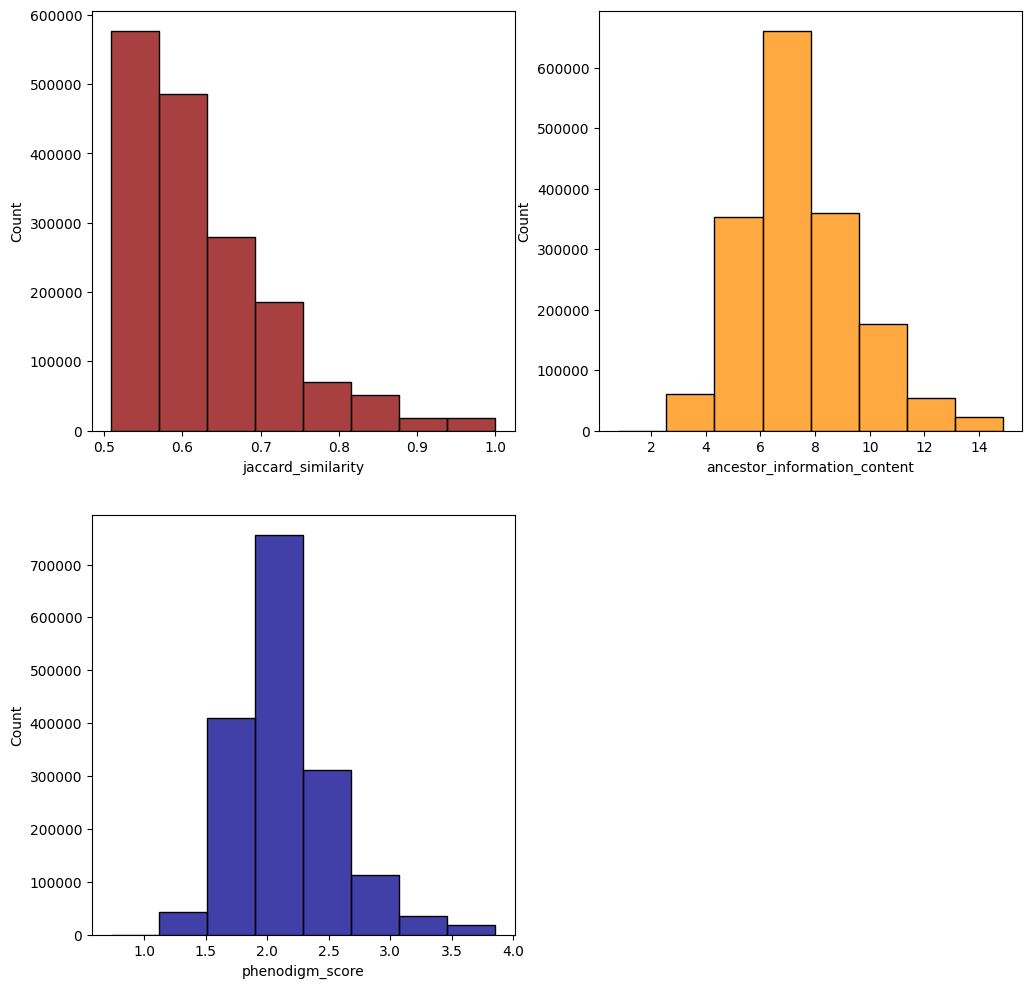

In [8]:
# Histograms
# These don't load everything but use a filter of jaccard >0.5,
# as in practice we don't really care about the very distant pairs
histdf = simsdf.select(metrics).filter(pl.col(metrics[0]) > 0.5).collect()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
snl.histplot(histdf, x=metrics[0], bins=8, color="darkred", ax=axs[0, 0])
snl.histplot(histdf, x=metrics[1], bins=8, color="darkorange", ax=axs[0, 1])
snl.histplot(histdf, x=metrics[2], bins=8, color="darkblue", ax=axs[1, 0])
axs[1, 1].axis('off')

### Embeddings for HP through OntoGPT and GPT-3.5

The basic idea here is to get all term labels, get embedding for each, and get cosine sim for each pair.
OntoGPT has the `entity-similarity` command already to do the latter two of these.

In [9]:
embed_cosimfile = 'hp_vs_hp_embed_cosim.tsv'

In [26]:
# Get all the term CURIEs
all_term_ids = set(pl.concat([simsdf["subject_id"], simsdf["object_id"], simsdf["ancestor_id"]]))
all_term_ids

{'HP:0001604',
 'HP:0001605',
 'HP:0001608',
 'HP:0001609',
 'HP:0001611',
 'HP:0001612',
 'HP:0001615',
 'HP:0001618',
 'HP:0001621',
 'HP:0001686',
 'HP:0003470',
 'HP:0005934',
 'HP:0007024',
 'HP:0008757',
 'HP:0009088',
 'HP:0012049',
 'HP:0012820',
 'HP:0012821',
 'HP:0012822',
 'HP:0025429',
 'HP:0025430',
 'HP:0025431',
 'HP:0031801',
 'HP:0100271',
 'HP:0200046'}

In [29]:
# Prep that term list
all_term_str = " ".join(all_term_ids)

In [32]:
# Get cosine sim
!ontogpt entity-similarity -r sqlite:obo:hp {all_term_str} -o {embed_cosimfile} -O yaml

In [33]:
!head {embed_cosimfile}

subject_id	subject_label	object_id	object_label	embedding_cosine_similarity	object_rank_for_subject
HP:0001615	Hoarse cry	HP:0001615	Hoarse cry	1.0000000000000002	0
HP:0001615	Hoarse cry	HP:0001612	Weak cry	0.928651658031122	1
HP:0001615	Hoarse cry	HP:0001608	Abnormality of the voice	0.9232128558034752	2
HP:0001615	Hoarse cry	HP:0001609	Hoarse voice	0.9198167123184476	3
HP:0001615	Hoarse cry	HP:0001686	Loss of voice	0.9166518643996694	4
HP:0001615	Hoarse cry	HP:0025430	High-pitched cry	0.9142521592726314	5
HP:0001615	Hoarse cry	HP:0025429	Abnormal cry	0.9111619386759381	6
HP:0001615	Hoarse cry	HP:0200046	Cat cry	0.8921291710166889	7
HP:0001615	Hoarse cry	HP:0001621	Weak voice	0.8860536218064554	8


In [45]:
embed_cosimsdf = pl.read_csv(embed_cosimfile, separator='\t')
embed_cosimsdf

subject_id,subject_label,object_id,object_label,embedding_cosine_similarity,object_rank_for_subject
str,str,str,str,f64,i64
"""HP:0001615""","""Hoarse cry""","""HP:0001615""","""Hoarse cry""",1.0,0
"""HP:0001615""","""Hoarse cry""","""HP:0001612""","""Weak cry""",0.928652,1
"""HP:0001615""","""Hoarse cry""","""HP:0001608""","""Abnormality of…",0.923213,2
"""HP:0001615""","""Hoarse cry""","""HP:0001609""","""Hoarse voice""",0.919817,3
"""HP:0001615""","""Hoarse cry""","""HP:0001686""","""Loss of voice""",0.916652,4
"""HP:0001615""","""Hoarse cry""","""HP:0025430""","""High-pitched c…",0.914252,5
"""HP:0001615""","""Hoarse cry""","""HP:0025429""","""Abnormal cry""",0.911162,6
"""HP:0001615""","""Hoarse cry""","""HP:0200046""","""Cat cry""",0.892129,7
"""HP:0001615""","""Hoarse cry""","""HP:0001621""","""Weak voice""",0.886054,8


### Combined plot

In [47]:
# Join the dfs
simsdf = simsdf.with_columns(simsdf.select(pl.col("subject_id") + "+" + pl.col("object_id")))
embed_cosimsdf = embed_cosimsdf.with_columns(embed_cosimsdf.select(pl.col("subject_id") + "+" + pl.col("object_id")))
simsdf = simsdf.join(embed_cosimsdf, on="subject_id")

In [48]:
simsdf

subject_id,subject_label,subject_source,object_id,object_label,object_source,ancestor_id,ancestor_label,ancestor_source,object_information_content,subject_information_content,ancestor_information_content,jaccard_similarity,cosine_similarity,dice_similarity,phenodigm_score,subject_label_right,object_id_right,object_label_right,embedding_cosine_similarity,object_rank_for_subject
str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,f64,str,str,str,f64,i64
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001615""","""Hoarse cry""","""None""","""HP:0001615""","""Hoarse cry""","""None""","""None""","""None""",14.863509,1.0,"""None""","""None""",3.855322,"""Hoarse cry""","""HP:0001615""","""Hoarse cry""",1.0,0
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001612""","""Weak cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.428571,"""None""","""None""",2.098831,"""Hoarse cry""","""HP:0001612""","""Weak cry""",0.928652,1
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.6,"""None""","""None""",2.48337,"""Hoarse cry""","""HP:0001608""","""Abnormality of…",0.923213,2
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001609""","""Hoarse voice""","""None""","""HP:0001609""","""Hoarse voice""","""None""","""None""","""None""",13.863509,0.8,"""None""","""None""",3.330286,"""Hoarse cry""","""HP:0001609""","""Hoarse voice""",0.919817,3
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001686""","""Loss of voice""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.5,"""None""","""None""",2.266996,"""Hoarse cry""","""HP:0001686""","""Loss of voice""",0.916652,4
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0025430""","""High-pitched c…","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.428571,"""None""","""None""",2.098831,"""Hoarse cry""","""HP:0025430""","""High-pitched c…",0.914252,5
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0025429""","""Abnormal cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.5,"""None""","""None""",2.266996,"""Hoarse cry""","""HP:0025429""","""Abnormal cry""",0.911162,6
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0200046""","""Cat cry""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.428571,"""None""","""None""",2.098831,"""Hoarse cry""","""HP:0200046""","""Cat cry""",0.892129,7
"""HP:0001615+HP:…","""Hoarse cry""","""None""","""HP:0001621""","""Weak voice""","""None""","""HP:0001608""","""Abnormality of…","""None""","""None""","""None""",10.278546,0.5,"""None""","""None""",2.266996,"""Hoarse cry""","""HP:0001621""","""Weak voice""",0.886054,8


(0.0, 1.0, 0.0, 1.0)

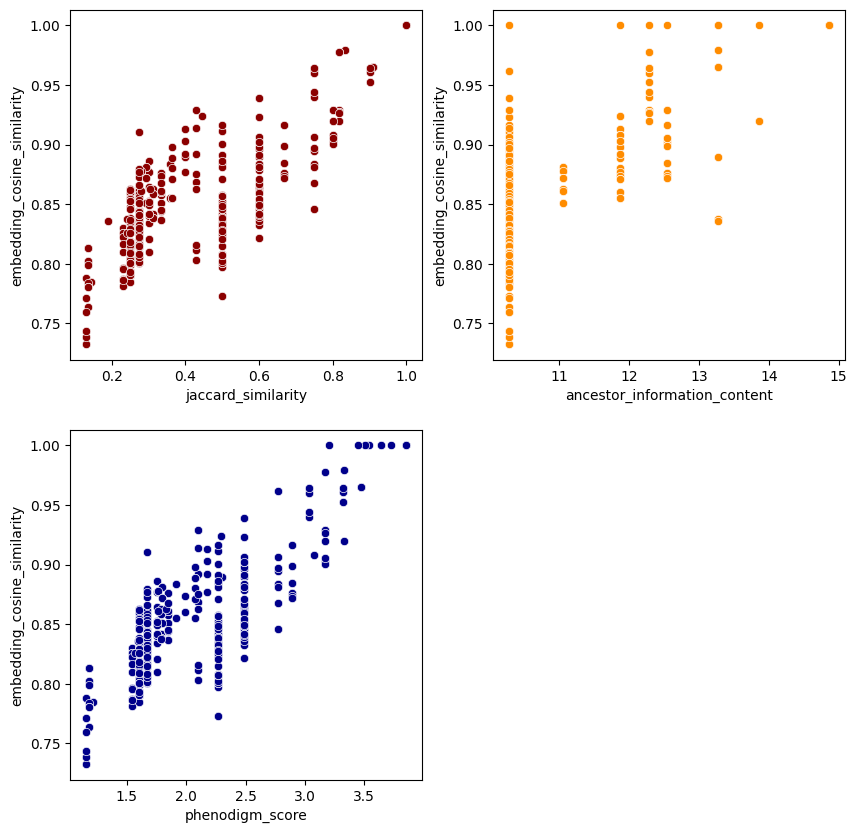

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
snl.scatterplot(simsdf, x='jaccard_similarity', y='embedding_cosine_similarity', color="darkred", ax=axs[0, 0])
snl.scatterplot(simsdf, x='ancestor_information_content', y='embedding_cosine_similarity', color="darkorange", ax=axs[0, 1])
snl.scatterplot(simsdf, x='phenodigm_score', y='embedding_cosine_similarity', color="darkblue", ax=axs[1, 0])
axs[1, 1].axis('off')